In [106]:
import pandas as pd
import xgboost as xgb
import numpy as np
import random
from sportsreference.ncaab.teams import Teams
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
##One I found online

In [3]:
import pandas as pd
import numpy
import math
import csv
import random
from sklearn import cross_validation, linear_model, model_selection
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

C:\Users\bdraus\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
#folder = 'C:\Users\bdraus\Documents\Python Scripts\Practice\DataFiles'
season_data = pd.read_csv(r"C:\Users\bdraus\Documents\Python Scripts\Practice\DataFiles\RegularSeasonDetailedResults.csv")
tourney_data = pd.read_csv(r"C:\Users\bdraus\Documents\Python Scripts\Practice\DataFiles\NCAATourneyDetailedResults.csv")
seeds = pd.read_csv(r"C:\Users\bdraus\Documents\Python Scripts\Practice\DataFiles\NCAATourneySeeds.csv")
frames = [season_data, tourney_data]
#combines season and tourney data
all_data = pd.concat(frames)
stat_fields = ['score', 'fga', 'fgp', 'fga3', '3pp', 'ftp', 'or', 'dr',
                   'ast', 'to', 'stl', 'blk', 'pf']
prediction_year = 2017
base_elo = 1600
team_elos = {}
team_stats = {}
X = []
y = []
submission_data = []
def initialize_data():
    for i in range(1985, prediction_year+1):
        #create an empty set for every year of the tournament
        team_elos[i] = {}
        team_stats[i] = {}
initialize_data()

In [14]:
all_data.head()

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [18]:
def get_elo(season, team):
    try:
        #looks up team elo, if not there go to next step
        return team_elos[season][team]
    except:
        try:
            # Get the previous season's ending value.
            team_elos[season][team] = team_elos[season-1][team]
            return team_elos[season][team]
        except:
            # Get the starter elo.
            team_elos[season][team] = base_elo
            return team_elos[season][team]

def calc_elo(win_team, lose_team, season):
    #grab winner elo
    winner_rank = get_elo(season, win_team)
    #grab loser elo
    loser_rank = get_elo(season, lose_team)
    #find the difference
    rank_diff = winner_rank - loser_rank
    #exponent is difference in elo *-1/400
    exp = (rank_diff * -1) / 400
    
    odds = 1 / (1 + math.pow(10, exp))
    if winner_rank < 2100:
        k = 32
    elif winner_rank >= 2100 and winner_rank < 2400:
        k = 24
    else:
        k = 16
    new_winner_rank = round(winner_rank + (k * (1 - odds)))
    new_rank_diff = new_winner_rank - winner_rank
    
    #loser goes down by same amount that winner goes up
    new_loser_rank = loser_rank - new_rank_diff
    return new_winner_rank, new_loser_rank

#gets average stats over each season
def get_stat(season, team, field):
    try:
        l = team_stats[season][team][field]
        return sum(l) / float(len(l))
    except:
        return 0
    
def update_stats(season, team, fields):
    if team not in team_stats[season]:
        team_stats[season][team] = {}
    for key, value in fields.items():
        # Make sure we have the field.
        if key not in team_stats[season][team]:
            team_stats[season][team][key] = []
        if len(team_stats[season][team][key]) >= 9:
            team_stats[season][team][key].pop()
        team_stats[season][team][key].append(value)
        
def predict_winner(team_1, team_2, model, season, stat_fields):
    features = []
    # Team 1
    features.append(get_elo(season, team_1))
    for stat in stat_fields:
        features.append(get_stat(season, team_1, stat))
    # Team 2
    features.append(get_elo(season, team_2))
    for stat in stat_fields:
        features.append(get_stat(season, team_2, stat))
    return model.predict_proba([features])

In [ ]:
predict_winner(1211,1233,model,'2017',)

    wfgm :  field goals made
        wfga :  field goals attempted
        wfgm3 :  three pointers made
        wfga3 :  three pointers attempted
        wftm :  free throws made
        wfta :  free throws attempted
        wor :  offensive rebounds
        wdr :  defensive rebounds
        wast :  assists
        wto :  turnovers
        wstl :  steals
        wblk :  blocks
        wpf :  personal fouls

        fgp :  field goal percentage
        3pp :  three point percentage
        ftp:  free throw percentage
        elo:  https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/

In [7]:
def build_season_data(all_data):
    # Calculate the elo for every game for every team, each season.
    # Store the elo per season so we can retrieve their end elo
    # later in order to predict the tournaments without having to
    # inject the prediction into this loop.
    for index, row in all_data.iterrows():
        
        # Used to skip matchups where we don't have usable stats yet.
        skip = 0
        # Get starter or previous elos.
        team_1_elo = get_elo(row['Season'], row['WTeamID'])
        team_2_elo = get_elo(row['Season'], row['LTeamID'])
        # Add 100 to the home team (# taken from Nate Silver analysis.)
        if row['WLoc'] == 'H':
            team_1_elo += 100
        elif row['WLoc'] == 'A':
            team_2_elo += 100         
        # We'll create some arrays to use later.
        team_1_features = [team_1_elo]
        team_2_features = [team_2_elo]
        # Build arrays out of the stats we're tracking..
        for field in stat_fields:
            team_1_stat = get_stat(row['Season'], row['WTeamID'], field)
            team_2_stat = get_stat(row['Season'], row['LTeamID'], field)
            if team_1_stat is not 0 and team_2_stat is not 0:
                team_1_features.append(team_1_stat)
                team_2_features.append(team_2_stat)
            else:
                skip = 1
        if skip == 0:  # Make sure we have stats.
            # Randomly select left and right and 0 or 1 so we can train
            # for multiple classes.
            if random.random() > 0.5:
                X.append(team_1_features + team_2_features)
                y.append(0)
            else:
                X.append(team_2_features + team_1_features)
                y.append(1)
        # AFTER we add the current stuff to the prediction, update for
        # next time. Order here is key so we don't fit on data from the
        # same game we're trying to predict.
        if row['WFTA'] != 0 and row['LFTA'] != 0:
            stat_1_fields = {
                'score': row['WScore'],
                'fgp': row['WFGM'] / row['WFGA'] * 100,
                'fga': row['WFGA'],
                'fga3': row['WFGA3'],
                '3pp': row['WFGM3'] / row['WFGA3'] * 100,
                'ftp': row['WFTM'] / row['WFTA'] * 100,
                'or': row['WOR'],
                'dr': row['WDR'],
                'ast': row['WAst'],
                'to': row['WTO'],
                'stl': row['WStl'],
                'blk': row['WBlk'],
                'pf': row['WPF']
            }            
            stat_2_fields = {
                'score': row['LScore'],
                'fgp': row['LFGM'] / row['LFGA'] * 100,
                'fga': row['LFGA'],
                'fga3': row['LFGA3'],
                '3pp': row['LFGM3'] / row['LFGA3'] * 100,
                'ftp': row['LFTM'] / row['LFTA'] * 100,
                'or': row['LOR'],
                'dr': row['LDR'],
                'ast': row['LAst'],
                'to': row['LTO'],
                'stl': row['LStl'],
                'blk': row['LBlk'],
                'pf': row['LPF']
            }
            update_stats(row['Season'], row['WTeamID'], stat_1_fields)
            update_stats(row['Season'], row['LTeamID'], stat_2_fields)
        # Now that we've added them, calc the new elo.
        new_winner_rank, new_loser_rank = calc_elo(
            row['WTeamID'], row['LTeamID'], row['Season'])
        team_elos[row['Season']][row['WTeamID']] = new_winner_rank
        team_elos[row['Season']][row['LTeamID']] = new_loser_rank
    return X, y
X, y = build_season_data(all_data)

In [8]:
model = linear_model.LogisticRegression()
print("Let's hope to be correct 75% of the time")
print(cross_validation.cross_val_score(model, numpy.array(X), numpy.array(y), cv=10, scoring='accuracy', n_jobs=-1).mean())
_ = model.fit(X, y)

Let's hope to be correct 75% of the time
0.7268598802339697


In [9]:
tourney_teams = []
for index, row in seeds.iterrows():
    
    if row['Season'] == prediction_year:
        tourney_teams.append(row['TeamID'])
tourney_teams.sort()

for team_1 in tourney_teams:
    for team_2 in tourney_teams:
        if team_1 < team_2:
            prediction = predict_winner(
                team_1, team_2, model, prediction_year, stat_fields)
            label = str(prediction_year) + '_' + str(team_1) + '_' + \
                str(team_2)
            submission_data.append([label, prediction[0][0]])

[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[2147]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[1992]
[2064]
[2064]
[2064]
[2064]
[2064]
[2064]
[2064]
[2064]
[2064]
[2064]

[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[2010]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1913]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1514]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]
[1905]

In [74]:
print("Writing %d results." % len(submission_data))
submission_data2=pd.DataFrame(submission_data)
submission_data2.to_csv("submission1.csv", index=False)
def build_team_dict():
    team_ids = pd.read_csv(r"C:\Users\bdraus\Documents\Python Scripts\Practice\Teams.csv")
    team_id_map = {}
    for index, row in team_ids.iterrows():
        team_id_map[row['Team_Id']] = row['Team_Name']
    return team_id_map
team_id_map = build_team_dict()
readable = []
less_readable = []  # A version that's easy to look up.
for pred in submission_data:
    parts = pred[0].split('_')
    less_readable.append(
        [team_id_map[int(parts[1])], team_id_map[int(parts[2])], pred[1]])
    # Order them properly.
    if pred[1] > 0.5:
        winning = int(parts[1])
        losing = int(parts[2])
        proba = pred[1]
    else:
        winning = int(parts[2])
        losing = int(parts[1])
        proba = 1 - pred[1]
    readable.append(
        [
            '%s beats %s: %f' %
            (team_id_map[winning], team_id_map[losing], proba)
        ]
    )
readable

Writing 2278 results.


[['Arizona beats Arkansas: 0.639205'],
 ['Arizona beats Baylor: 0.581000'],
 ['Arizona beats Bucknell: 0.927891'],
 ['Arizona beats Butler: 0.593481'],
 ['Arizona beats Cincinnati: 0.579502'],
 ['Arizona beats Creighton: 0.698634'],
 ['Arizona beats Dayton: 0.744144'],
 ['Arizona beats Duke: 0.508375'],
 ['Arizona beats ETSU: 0.900876'],
 ['Arizona beats FL Gulf Coast: 0.931668'],
 ['Arizona beats Florida: 0.587232'],
 ['Arizona beats Florida St: 0.621168'],
 ['Gonzaga beats Arizona: 0.528894'],
 ['Arizona beats Iona: 0.915445'],
 ['Arizona beats Iowa St: 0.589523'],
 ['Arizona beats Jacksonville St: 0.971737'],
 ['Kansas beats Arizona: 0.605696'],
 ['Arizona beats Kansas St: 0.710794'],
 ['Arizona beats Kent: 0.888798'],
 ['Kentucky beats Arizona: 0.606496'],
 ['Arizona beats Louisville: 0.544468'],
 ['Arizona beats Marquette: 0.700758'],
 ['Arizona beats Maryland: 0.733919'],
 ['Arizona beats Miami FL: 0.679304'],
 ['Arizona beats Michigan: 0.630211'],
 ['Arizona beats Michigan St: 0

In [91]:
df = pd.DataFrame(readable)
#Finalpredictions=pd.DataFrame(readable)
df.to_csv(r"C:\Users\bdraus\Documents\Python Scripts\Practice\Finalpredictions.csv", index=False)

In [89]:
print(df)

                                                0
0                Arizona beats Arkansas: 0.639205
1                  Arizona beats Baylor: 0.581000
2                Arizona beats Bucknell: 0.927891
3                  Arizona beats Butler: 0.593481
4              Arizona beats Cincinnati: 0.579502
5               Arizona beats Creighton: 0.698634
6                  Arizona beats Dayton: 0.744144
7                    Arizona beats Duke: 0.508375
8                    Arizona beats ETSU: 0.900876
9           Arizona beats FL Gulf Coast: 0.931668
10                Arizona beats Florida: 0.587232
11             Arizona beats Florida St: 0.621168
12                Gonzaga beats Arizona: 0.528894
13                   Arizona beats Iona: 0.915445
14                Arizona beats Iowa St: 0.589523
15        Arizona beats Jacksonville St: 0.971737
16                 Kansas beats Arizona: 0.605696
17              Arizona beats Kansas St: 0.710794
18                   Arizona beats Kent: 0.888798


In [58]:
def get_feature_importances(estimator, norm_order=1):
    """Retrieve or aggregate feature importances from estimator"""
    importances = getattr(estimator, "feature_importances_", None)

    if importances is None and hasattr(estimator, "coef_"):
        if estimator.coef_.ndim == 1:
            importances = np.abs(estimator.coef_)

        else:
            importances = np.linalg.norm(estimator.coef_, axis=0,
                                         ord=norm_order)

    elif importances is None:
        raise ValueError(
            "The underlying estimator %s has no `coef_` or "
            "`feature_importances_` attribute. Either pass a fitted estimator"
            " to SelectFromModel or call fit before calling transform."
            % estimator.__class__.__name__)

    return importances

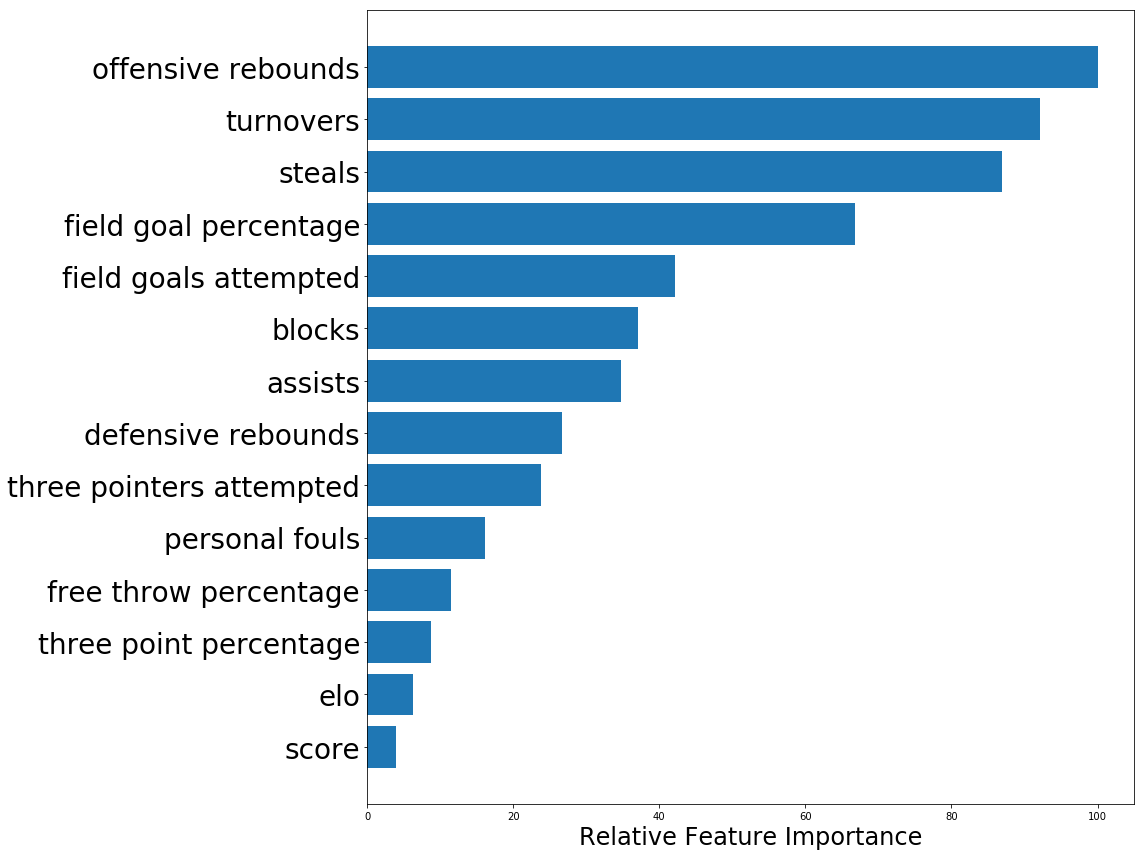

In [59]:
import numpy as np
import matplotlib.pyplot as plt

importances = np.array(get_feature_importances(model))[14:28]
statdict = np.array(['elo',
            'score',
            'field goals attempted',
            'field goal percentage',
            'three pointers attempted',
            'three point percentage',
            'free throw percentage',
            'offensive rebounds',
            'defensive rebounds',
            'assists',
            'turnovers',
            'steals',
            'blocks',
            'personal fouls',
           ],dtype='str')
    
feature_importance = abs(model.coef_[0][:14])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5


featfig = plt.figure(figsize=(16,12))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(statdict[sorted_idx], fontsize=28)
featax.set_xlabel('Relative Feature Importance',fontsize=24)

plt.tight_layout()   
plt.show()